In [ ]:
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip'
!mkdir /tmp/fonts
!unzip -o NotoSansCJKtc-hinted.zip -d /tmp/fonts/
!mv /tmp/fonts/NotoSansMonoCJKtc-Regular.otf /usr/share/fonts/truetype/NotoSansMonoCJKtc-Regular.otf -f
!rm -rf /tmp/fonts
!rm NotoSansCJKtc-hinted.zip
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

font_dirs = ['/usr/share/fonts/truetype/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
  font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = "Noto Sans Mono CJK TC"

In [ ]:
######策略篇程式交易練功房##########
###匯入套件

##########三寶
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
################
import tejapi

############ 接資料

In [ ]:
tejapi.ApiConfig.api_key=####yourkey

tejapi.ApiConfig.ignoretz = True

coid="2618"
start="2018-01-01"
end= "2022-02-17"
opts={'columns': ['coid', 'mdate', 'volume', 'close_adj','close_d','open_d']}

In [ ]:
fly=tejapi.get('TWN/EWPRCD',coid=coid,
                mdate={'gt':start,'lt':end},
                paginate=True,
                chinese_column_name=True,
                opts=opts
                )

In [ ]:
fly.set_index("日期",drop=True,inplace=True)

In [ ]:
fly


,證券碼,成交量(千股),收盤價-除權息,收盤價,開盤價
日期,,,,,
2018-01-02,2618,24410.411,13.5785,15.95,15.80
2018-01-03,2618,10399.399,13.6637,16.05,16.05
2018-01-04,2618,10116.726,13.6211,16.00,16.05
2018-01-05,2618,16325.731,13.7914,16.20,16.10
2018-01-08,2618,10548.509,13.6637,16.05,16.25
...,...,...,...,...,...
2022-02-09,2618,245624.664,28.4000,28.40,27.95
2022-02-10,2618,251728.456,28.8500,28.85,28.95
2022-02-11,2618,336632.699,30.1500,30.15,28.85


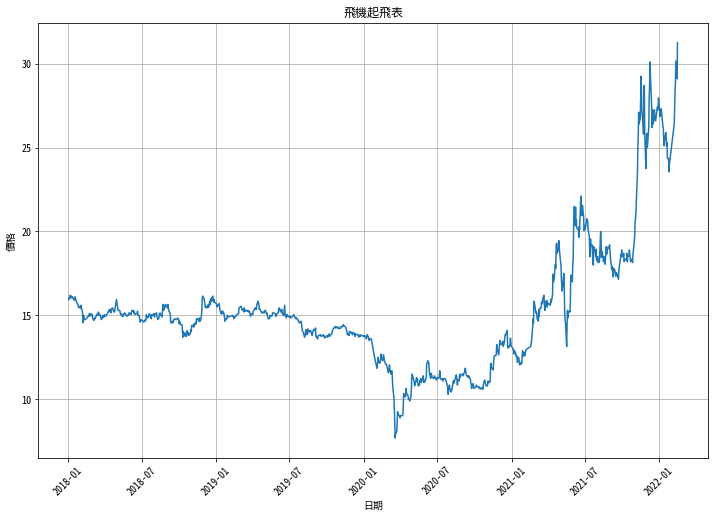

In [ ]:

plt.figure(facecolor='white',figsize=(12,8))
plt.plot(fly['收盤價'], label='收盤價')
plt.title("飛機起飛表")
plt.xticks(rotation=45) #X軸斜的
plt.xlabel('日期')
plt.ylabel('價格')
plt.grid() #格子
plt.show()

In [ ]:
def voltrade(df,p,q,r):
    df =df.copy()

    df["當日交易量"]=df["成交量(千股)"].rolling(p).mean()
    df["前五日總量"]=df["成交量(千股)"].rolling(q).sum()
    df[str(r)+"日均線"]=df["收盤價-除權息"].rolling(r).mean()
    
    ####扣除掉當日之平均
    
    df["前幾日平均"]=(df["前五日總量"]-df["當日交易量"])/(q-p)
    
    
    
    return df 


In [ ]:
r=5
stock=voltrade(fly, 1, 5, r)


In [56]:
stock


,證券碼,成交量(千股),收盤價-除權息,收盤價,開盤價,當日交易量,前五日總量,5日均線,前幾日平均
日期,,,,,,,,,
2018-01-02,2618,24410.411,13.5785,15.95,15.80,24410.411,NaN,NaN,NaN
2018-01-03,2618,10399.399,13.6637,16.05,16.05,10399.399,NaN,NaN,NaN
2018-01-04,2618,10116.726,13.6211,16.00,16.05,10116.726,NaN,NaN,NaN
2018-01-05,2618,16325.731,13.7914,16.20,16.10,16325.731,NaN,NaN,NaN
2018-01-08,2618,10548.509,13.6637,16.05,16.25,10548.509,71800.776,13.66368,15313.06675
...,...,...,...,...,...,...,...,...,...
2022-02-09,2618,245624.664,28.4000,28.40,27.95,245624.664,685264.342,25.94000,109909.91950
2022-02-10,2618,251728.456,28.8500,28.85,28.95,251728.456,885307.249,27.00000,158394.69825
2022-02-11,2618,336632.699,30.1500,30.15,28.85,336632.699,1186921.460,28.23000,212572.19025


In [ ]:

def buysell(company,a,b):
    company =company.copy()
    buy=[]
    sell=[]
    hold=0
    for i in range(len(company)):
    
        if  company["當日交易量"][i] > company["前幾日平均"][i]*a :
            sell.append(np.nan)
            if hold !=1:
                buy.append(company["收盤價-除權息"][i])
                
                hold = 1
            else: 
                buy.append(np.nan)

        
        elif company["當日交易量"][i]<company["前幾日平均"][i]*b :
            buy.append(np.nan)
            if hold !=0:
                sell.append(company["收盤價-除權息"][i])
                hold = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    a=(buy,sell)
        
    company['Buy_Signal_Price']=a[0]
    company['Sell_Signal_Price']=a[1]
    company["買賣股數1"]=company['Buy_Signal_Price'].apply(lambda x : 1000 if x >0 else 0)
    company["買賣股數2"]=company['Sell_Signal_Price'].apply(lambda x : -1000 if x >0 else 0  )
    company["買賣股數"]=company["買賣股數1"]+ company["買賣股數2"]
    
    return company
def buy_sell(company,a,b):
    company =company.copy()

    buy=[]
    sell=[]
    hold=0
    for i in range(len(company)):
    
        if  (company["當日交易量"][i] > company["前幾日平均"][i]*a ) & (company["收盤價-除權息"][i] > company[str(r)+"日均線"][i]  ):
            sell.append(np.nan)
            if hold !=1:
                buy.append(company["收盤價-除權息"][i])
                
                hold = 1
            else: 
                buy.append(np.nan)

        
        elif (company["當日交易量"][i]<company["前幾日平均"][i]*b) & (company["收盤價-除權息"][i] < company[str(r)+"日均線"][i]  ) :
            buy.append(np.nan)
            if hold !=0:
                sell.append(company["收盤價-除權息"][i])
                hold = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    a=(buy,sell)
        
    company['Buy_Signal_Price']=a[0]
    company['Sell_Signal_Price']=a[1]
    company["買賣股數1"]=company['Buy_Signal_Price'].apply(lambda x : 1000 if x >0 else 0)
    company["買賣股數2"]=company['Sell_Signal_Price'].apply(lambda x : -1000 if x >0 else 0  )
    company["買賣股數"]=company["買賣股數1"]+ company["買賣股數2"]
    
    return company

In [ ]:
def plot(fly):
#Visually show the stock buy and sell signal
    plt.figure(figsize=(12.2,4.5))
# ^ = shift + 6
    plt.scatter(fly.index,fly['Buy_Signal_Price'],color='red', label='Buy',marker='^',alpha=1)
#小寫的v
    plt.scatter(fly.index,fly['Sell_Signal_Price'],color='green', label='Sell',marker='v',alpha=1)
    plt.plot(fly['收盤價-除權息'], label='Close Price', alpha=0.35)
    plt.title('Close Price Buy & Sell Signals')
#字斜45度角
    plt.xticks(rotation=45)
    plt.xlabel('Date')  
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    return  plt.show()

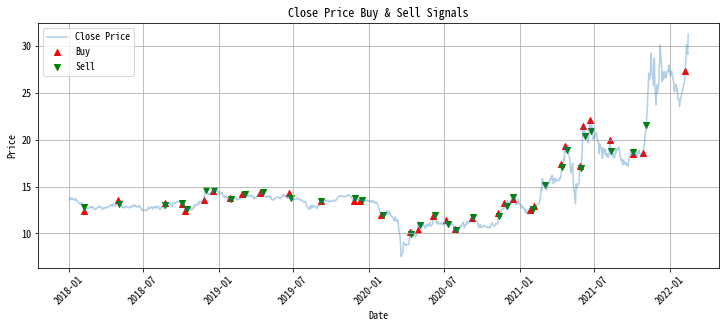

In [ ]:

vol=buysell(stock,2.5,0.75)
plot(buysell(stock,2.5,0.75))

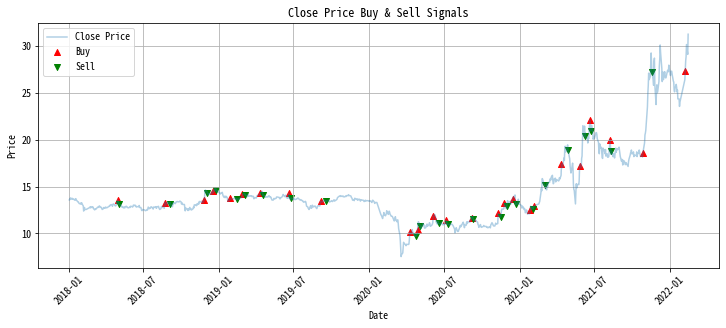

In [ ]:
volma=buy_sell(stock,2.5,0.75)      
plot(buy_sell(stock,2.5,0.75))

In [ ]:
def pvtwo(fly):
  fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15, 10))
  ax1, ax2 = axes.flatten()
  ax1.scatter(fly.index,fly['Buy_Signal_Price'],color='red', label='Buy',marker='^',alpha=1)

  ax1.scatter(fly.index,fly['Sell_Signal_Price'],color='green', label='Sell',marker='v',alpha=1)
  ax1.plot(fly['收盤價-除權息'], label='Close Price', alpha=0.35)
  ax1.set_title('Close Price Buy & Sell Signals')
  ax1.set_ylabel('Price')
  ax1.grid(linestyle="--",alpha=0.8)

  red_pred = np.where(fly["收盤價"] > fly["開盤價"],fly["成交量(千股)"], 0)
  blue_pred = np.where(fly["收盤價"] <  fly["開盤價"], fly["成交量(千股)"], 0)
  ax2.bar(fly.index,red_pred, facecolor="red")
  ax2.bar(fly.index,blue_pred,facecolor="green")
  plt.legend(loc='best')
  return plt.show()
############疊在同一張圖


In [ ]:
def pvsame(fly):
  fig, ax1 = plt.subplots( figsize=(15, 10))
  ax2 = ax1.twinx()
  ax1.scatter(fly.index,fly['Buy_Signal_Price'],color='red', label='Buy',marker='^',alpha=1)

  ax1.scatter(fly.index,fly['Sell_Signal_Price'],color='green', label='Sell',marker='v',alpha=1)
  ax1.plot(fly['收盤價-除權息'], label='Close Price', alpha=0.35)
  ax1.set_title('Close Price Buy & Sell Signals')
  ax1.set_ylabel('Price')
  ax1.grid(linestyle="--",alpha=0.8)

  red_pred = np.where(fly["收盤價"] > fly["開盤價"],fly["成交量(千股)"], 0)
  blue_pred = np.where(fly["收盤價"] <  fly["開盤價"], fly["成交量(千股)"], 0)
  ax2.bar(fly.index,red_pred, facecolor="red",width=1)
  ax2.bar(fly.index,blue_pred,facecolor="green",width=1)
  plt.legend(loc='best')
  return plt.show()

No handles with labels found to put in legend.


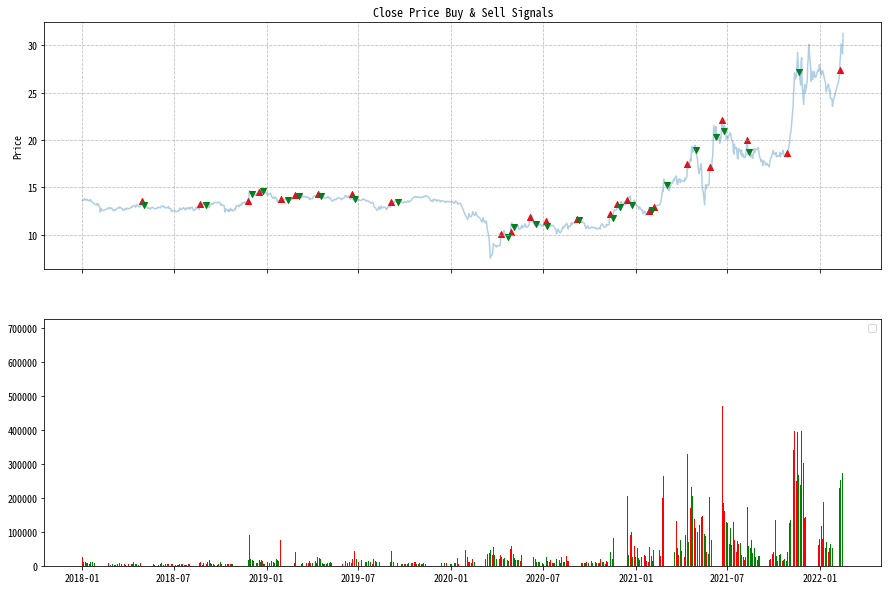

No handles with labels found to put in legend.


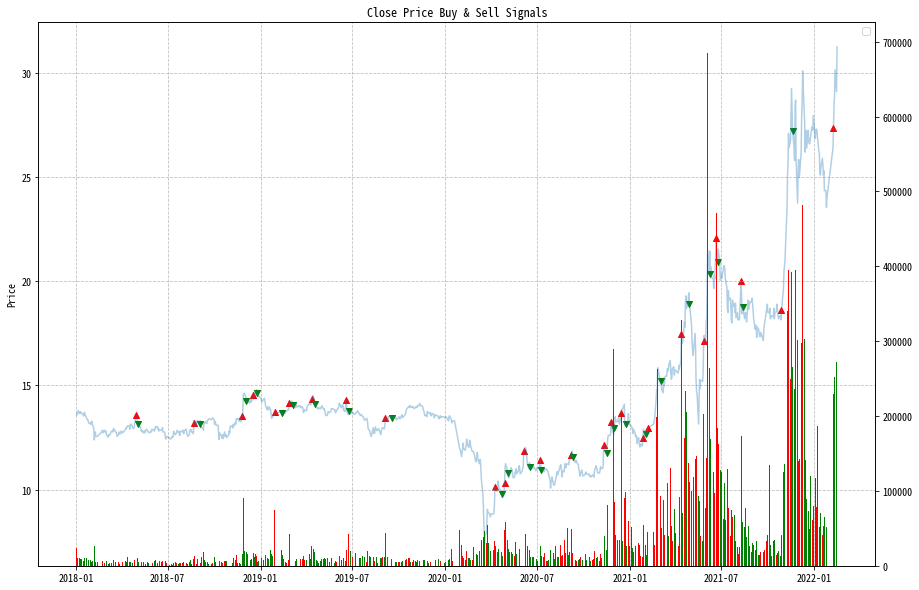

In [ ]:
pvtwo(volma)
pvsame(volma)

In [ ]:

def target_return(data, principal):
    data=data.copy()
    #計算成本
    data['手續費'] = data['收盤價-除權息']* abs(data['買賣股數'])*0.001425
    data['手續費'] = np.where((data['手續費']>0)&(data['手續費'] <20), 20, data['手續費'])
    data['證交稅'] = np.where(data['買賣股數']<0, data['收盤價-除權息']* abs(data['買賣股數'])*0.003, 0)
    data['摩擦成本'] = (data['手續費'] + data['證交稅']).apply(np.floor)
    
    #計算資產價值
    data['股票價值'] = data['買賣股數'].cumsum() * data['收盤價-除權息']
    data['現金價值'] = principal - data['摩擦成本'] + (data['收盤價-除權息']* -data['買賣股數']).cumsum() 
    data['資產價值'] = data['股票價值'] + data['現金價值']
    
    #計算報酬率
    data['當日價值變動(%)'] = (data['資產價值']/data['資產價值'].shift(1) - 1)*100
    data['累計報酬(%)'] = (data['資產價值']/principal - 1)*100
    
    return data

In [ ]:
keep=vol.copy()
keep["買賣股數"]=0
keep["買賣股數"][0]=1000
keep["買賣股數"][len(keep)-1]=-1000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
volreturn1 = target_return( volma, principal = 16000)
volreturn2 = target_return( vol, principal = 16000)
volreturn3 = target_return( keep, principal = 16000)

In [57]:
volreturn1

,證券碼,成交量(千股),收盤價-除權息,收盤價,開盤價,當日交易量,前五日總量,5日均線,前幾日平均,Buy_Signal_Price,Sell_Signal_Price,買賣股數1,買賣股數2,買賣股數,手續費,證交稅,摩擦成本,股票價值,現金價值,資產價值,當日價值變動(%),累計報酬(%)
日期,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,2618,24410.411,13.5785,15.95,15.80,24410.411,NaN,NaN,NaN,NaN,NaN,0,0,0,0.0,0.0,0.0,0.0,16000.0,16000.0,NaN,0.00000
2018-01-03,2618,10399.399,13.6637,16.05,16.05,10399.399,NaN,NaN,NaN,NaN,NaN,0,0,0,0.0,0.0,0.0,0.0,16000.0,16000.0,0.000000,0.00000
2018-01-04,2618,10116.726,13.6211,16.00,16.05,10116.726,NaN,NaN,NaN,NaN,NaN,0,0,0,0.0,0.0,0.0,0.0,16000.0,16000.0,0.000000,0.00000
2018-01-05,2618,16325.731,13.7914,16.20,16.10,16325.731,NaN,NaN,NaN,NaN,NaN,0,0,0,0.0,0.0,0.0,0.0,16000.0,16000.0,0.000000,0.00000
2018-01-08,2618,10548.509,13.6637,16.05,16.25,10548.509,71800.776,13.66368,15313.06675,NaN,NaN,0,0,0,0.0,0.0,0.0,0.0,16000.0,16000.0,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-09,2618,245624.664,28.4000,28.40,27.95,245624.664,685264.342,25.94000,109909.91950,NaN,NaN,0,0,0,0.0,0.0,0.0,28400.0,-1048.2,27351.8,4.142584,70.94875
2022-02-10,2618,251728.456,28.8500,28.85,28.95,251728.456,885307.249,27.00000,158394.69825,NaN,NaN,0,0,0,0.0,0.0,0.0,28850.0,-1048.2,27801.8,1.645230,73.76125
2022-02-11,2618,336632.699,30.1500,30.15,28.85,336632.699,1186921.460,28.23000,212572.19025,NaN,NaN,0,0,0,0.0,0.0,0.0,30150.0,-1048.2,29101.8,4.675956,81.88625


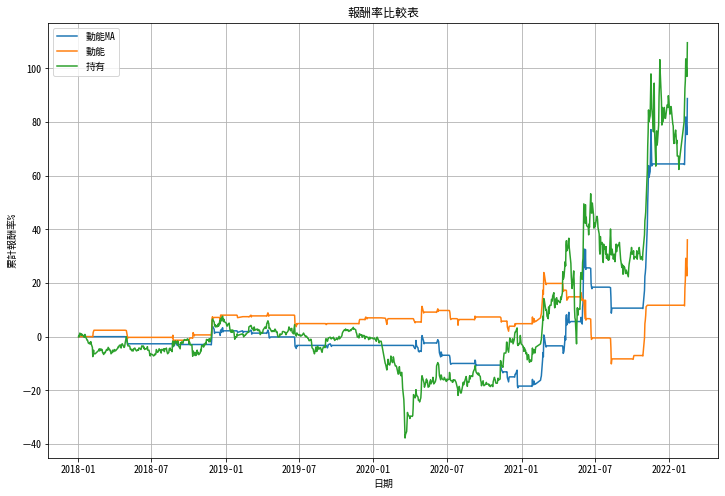

In [ ]:
plt.figure(facecolor='white',figsize=(12,8))
plt.plot(volreturn1.index,volreturn1['累計報酬(%)'], label = "動能MA")S
plt.plot(volreturn3.index,volreturn3['累計報酬(%)'], label = "持有")
plt.xlabel('日期')
plt.title("報酬率比較表")
plt.ylabel('累計報酬率%')
plt.legend()
plt.grid()
plt.show()

In [ ]:
cagr = [(((volreturn1['累計報酬(%)'].values[-1]*0.01 + 1)**(252/len(volreturn1))) - 1)*100, 
        ((volreturn2['累計報酬(%)'].values[-1]*0.01 + 1)**(252/len(volreturn2)) - 1)*100, 
        ((volreturn2['累計報酬(%)'].values[-1]*0.01 + 1)**(252/len(volreturn3)) - 1)*100]




In [ ]:
std = [volreturn1['當日價值變動(%)'].std()*(252**0.5), volreturn2['當日價值變動(%)'].std()*(252**0.5), 
       volreturn3['當日價值變動(%)'].std()*(252**0.5)]

In [ ]:
sharpe_ratio = [(cagr[0] - 1)/std[0],(cagr[1] - 1)/std[1],(cagr[2] - 1)/std[2]]

In [ ]:
sharpe_ratio


[0.8975475357237737, 0.5018125931589615, 0.23078658634606203]

In [ ]:
performance = pd.DataFrame([cagr,std,sharpe_ratio], columns = ['動能MA','動能','持有'], 
                           index = ['年化報酬(%)','年化標準差(%)','夏普比率'])
performance

,動能MA,動能,持有
年化報酬(%),17.306498,8.049518,8.049518
年化標準差(%),18.167838,14.048109,30.545615
夏普比率,0.897548,0.501813,0.230787
